In [1]:
import math
import time
import sys
import pandas as pd
import numpy as np
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import style
import paste as pst
import ot
import seaborn
from anndata import AnnData
import yaml
from pathlib import Path
import os
import random
import torch

from typing import List, Mapping, Optional, Union
import random

/rd2/user/xiacr/spatialGLUE/env/paste/conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
sys.path.append("../../../scSLAT/viz")
from multi_dataset import match_3D_celltype, match_3D_multi

In [4]:
rna = sc.read_h5ad('../glue_rna-E11_20um.h5ad')
atac = sc.read_h5ad('../glue_atac-E11_20um.h5ad')

In [5]:
atac.obsm['spatial_bak'] = atac.obsm['spatial'].copy()
atac.obsm['spatial'] = np.array([atac.obsm['spatial_bak'][:,0],-atac.obsm['spatial_bak'][:,1]]).T

In [13]:
alpha = 0.1
pi12 = pst.pairwise_align(rna, atac, use_gpu=True, use_rep='X_glue',
                          backend=ot.backend.TorchBackend(), 
                          alpha=alpha, norm=True, verbose=True)

gpu is available, using gpu.
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|     nan|0.000000e+00|0.000000e+00
    1|     nan|     nan|     nan
    2|     nan|     nan|     nan
    3|     nan|     nan|     nan
    4|     nan|     nan|     nan
    5|     nan|     nan|     nan
    6|     nan|     nan|     nan
    7|     nan|     nan|     nan
    8|     nan|     nan|     nan
    9|     nan|     nan|     nan
   10|     nan|     nan|     nan
   11|     nan|     nan|     nan
   12|     nan|     nan|     nan
   13|     nan|     nan|     nan
   14|     nan|     nan|     nan
   15|     nan|     nan|     nan
   16|     nan|     nan|     nan
   17|     nan|     nan|     nan
   18|     nan|     nan|     nan
   19|     nan|     nan|     nan
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
   20|     nan|     nan|     nan
   21|     nan|     nan|     nan
   22|     nan|     nan|     nan
   23|     n

In [14]:
result = pd.DataFrame(pi12)
matching_index = np.argmax(result.to_numpy(),axis=0)
matching = np.array([np.arange(result.shape[1]),matching_index])

In [15]:
rna_df = pd.DataFrame({'index':range(rna.shape[0]),
                          'x': rna.obsm['spatial'][:,0],
                          'y': rna.obsm['spatial'][:,1],
                          'leiden':rna.obs['annotation']})

atac_df = pd.DataFrame({'index':range(atac.shape[0]),
                          'x': atac.obsm['spatial'][:,0],
                          'y': atac.obsm['spatial'][:,1],
                          'leiden':atac.obs['Clusters']})

/rd2/user/xiacr/SLAT/case/sptatial_multi-omics/other_methods/../../../scSLAT/viz/multi_dataset.py:204: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.celltypes = set(self.dataset_A[meta].append(self.dataset_B[meta]))


dataset1: 9 cell types; dataset2: 7 cell types; 
                    Total :16 celltypes; Overlap: 0 cell types 
                    Not overlap :[['Head mesenchyme', 'Connective tissue', 'Liver', 'Surface ectoderm', 'Brain', 'Heart', 'Spinal cord', 'Lung primordium', 'Mesenchyme', 'C6', 'C4', 'C5', 'C7', 'C2', 'C3', 'C1']]
Subsample 300 cell pairs from 2099


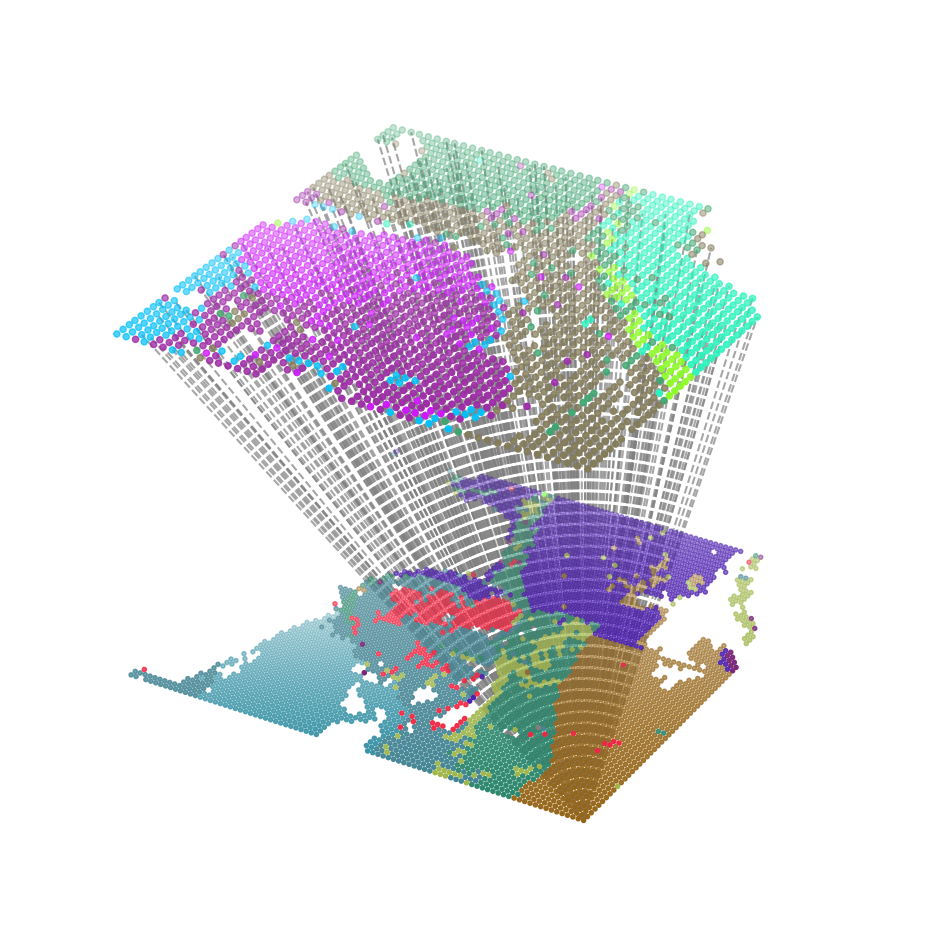

In [16]:
%matplotlib inline
multi_align = match_3D_multi(rna_df, atac_df, matching, meta='leiden', rotate=['y','y'],
                             scale_coordinate=True,subsample_size=300)

multi_align.draw_3D([12, 12], line_width =1.5, point_size=[9,20], hide_axis=True, 
                    show_error=False)

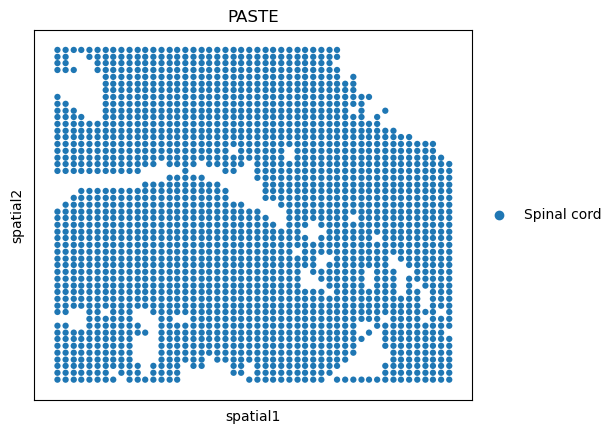

In [18]:
atac.obs['target_celltype'] = rna_df.iloc[matching[1,:],:]['leiden'].to_list()
atac.obs.target_celltype.value_counts()
sc.pl.spatial(atac, spot_size=10, color='target_celltype', frameon=True, title='PASTE')